In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud




In [41]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [42]:
calls = pd.read_csv("callsf0d4f5a.csv")
customers = pd.read_csv("customers2afd6ea.csv")
reasons = pd.read_csv("reason18315ff.csv")
sentiments = pd.read_csv("sentiment_statisticscc1e57a.csv")


# Data Preprocessing

In [43]:

calls['call_start_datetime'] = pd.to_datetime(calls['call_start_datetime'])
calls['agent_assigned_datetime'] = pd.to_datetime(calls['agent_assigned_datetime'])
calls['call_end_datetime'] = pd.to_datetime(calls['call_end_datetime'])

print(calls.isnull().sum())
print(customers.isnull().sum())
print(reasons.isnull().sum())
print(sentiments.isnull().sum())

calls = calls.dropna(subset=['call_end_datetime'])


call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
dtype: int64
customer_id             0
customer_name           0
elite_level_code    25767
dtype: int64
call_id                0
primary_call_reason    0
dtype: int64
call_id                      0
agent_id                     0
agent_tone                 217
customer_tone                0
average_sentiment          109
silence_percent_average      0
dtype: int64


In [44]:
reasons['primary_call_reason'] = reasons['primary_call_reason'].str.strip()

reasons['primary_call_reason'] = reasons['primary_call_reason'].str.lower()

reasons['primary_call_reason'] = reasons['primary_call_reason'].apply(lambda x: re.sub(r'\s+', ' ', x))

reasons['primary_call_reason'] = reasons['primary_call_reason'].str.replace('-', ' ')

unique_reasons = reasons['primary_call_reason'].unique()
print(unique_reasons)


['voluntary cancel' 'booking' 'irrops' 'upgrade' 'seating' 'mileage plus'
 'checkout' 'voluntary change' 'post flight' 'check in' 'other topics'
 'communications' 'schedule change' 'products & services'
 'digital support' 'disability' 'unaccompanied minor' 'baggage'
 'traveler updates' 'etc' 'products and services']


In [45]:
# Merge the datasets into one dataframe
merged_data = pd.merge(calls, reasons, on='call_id', how='left')
merged_data = pd.merge(merged_data, sentiments, on=['call_id', 'agent_id'], how='left')
merged_data = pd.merge(merged_data, customers, on='customer_id', how='left')

print(merged_data.head())


      call_id  customer_id  agent_id call_start_datetime  \
0  4667960400   2033123310    963118 2024-07-31 23:56:00   
1  1122072124   8186702651    519057 2024-08-01 00:03:00   
2  6834291559   2416856629    158319 2024-07-31 23:59:00   
3  2266439882   1154544516    488324 2024-08-01 00:05:00   
4  1211603231   5214456437    721730 2024-08-01 00:04:00   

  agent_assigned_datetime   call_end_datetime  \
0     2024-08-01 00:03:00 2024-08-01 00:34:00   
1     2024-08-01 00:06:00 2024-08-01 00:18:00   
2     2024-08-01 00:07:00 2024-08-01 00:26:00   
3     2024-08-01 00:10:00 2024-08-01 00:17:00   
4     2024-08-01 00:14:00 2024-08-01 00:23:00   

                                     call_transcript primary_call_reason  \
0  \n\nAgent: Thank you for calling United Airlin...    voluntary cancel   
1  \n\nAgent: Thank you for calling United Airlin...             booking   
2  \n\nAgent: Thank you for calling United Airlin...              irrops   
3  \n\nAgent: Thank you for calling Unit

In [46]:
merged_data.isnull().sum()

call_id                        0
customer_id                    0
agent_id                       0
call_start_datetime            0
agent_assigned_datetime        0
call_end_datetime              0
call_transcript                0
primary_call_reason         5157
agent_tone                   217
customer_tone                  0
average_sentiment            109
silence_percent_average        0
customer_name                  0
elite_level_code           25767
dtype: int64

In [47]:
# Calculate Handle Time (AHT): Time from when the agent picks up to when the call ends
merged_data['handle_time'] = (merged_data['call_end_datetime'] - merged_data['agent_assigned_datetime']).dt.total_seconds()

# Calculate Waiting Time (AST): Time from call start to when the agent picks up
merged_data['waiting_time'] = (merged_data['agent_assigned_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

# Calculate overall AHT and AST
AHT = merged_data['handle_time'].mean()
AST = merged_data['waiting_time'].mean()

print(f"Overall AHT: {AHT:.2f} seconds")
print(f"Overall AST: {AST:.2f} seconds")

Overall AHT: 697.05 seconds
Overall AST: 437.07 seconds


# Analysis

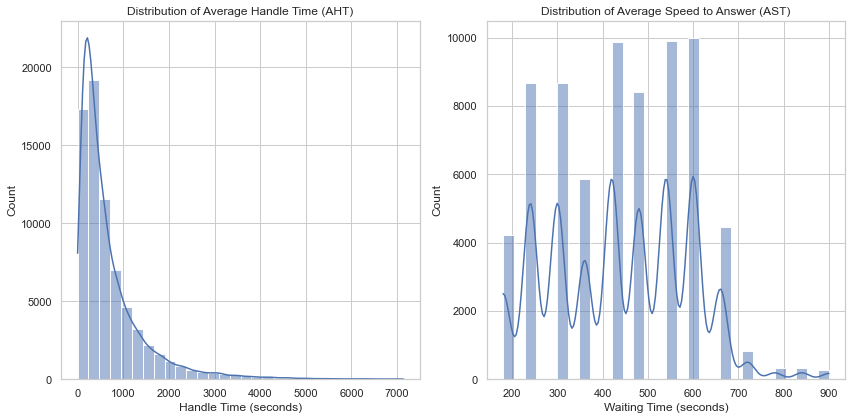

In [48]:
# Set plot style
sns.set(style="whitegrid")

# Plot distribution of AHT and AST
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(merged_data['handle_time'], kde=True, bins=30)
plt.title('Distribution of Average Handle Time (AHT)')
plt.xlabel('Handle Time (seconds)')

plt.subplot(1, 2, 2)
sns.histplot(merged_data['waiting_time'], kde=True, bins=30)
plt.title('Distribution of Average Speed to Answer (AST)')
plt.xlabel('Waiting Time (seconds)')

plt.tight_layout()
plt.show()

In [49]:
# Extract hour and weekday from call start datetime
merged_data['call_hour'] = merged_data['call_start_datetime'].dt.hour
merged_data['call_weekday'] = merged_data['call_start_datetime'].dt.weekday

# Group by hour and weekday to calculate AHT and AST
hourly_analysis = merged_data.groupby('call_hour').agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count',
}).reset_index()

weekday_analysis = merged_data.groupby('call_weekday').agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count',
}).reset_index()

# Show analysis of AHT and AST by hour and weekday
print("Hourly Analysis: \n", hourly_analysis.head())
print("Weekday Analysis: \n", weekday_analysis.head())


Hourly Analysis: 
    call_hour  handle_time  waiting_time  call_id
0          0   682.545772    438.831735     1147
1          1   757.087034    432.362345     1126
2          2   703.973384    436.825095     1052
3          3   706.529467    440.823199     1069
4          4   688.331762    430.235627     1061
Weekday Analysis: 
    call_weekday  handle_time  waiting_time  call_id
0             0   684.346662    434.968433     5227
1             1   679.095573    439.882196     5263
2             2   704.687017    439.486090     5176
3             3   699.901705    437.591768     6511
4             4   701.705426    436.443228     6579


# AHT and AST by hour

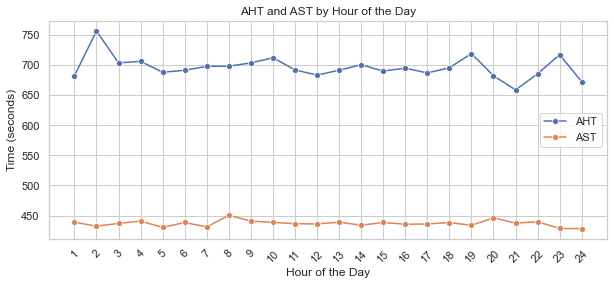

In [50]:
# Plot AHT and AST by hour
plt.figure(figsize=(10, 4))
sns.lineplot(x='call_hour', y='handle_time', data=hourly_analysis, label='AHT', marker='o')
sns.lineplot(x='call_hour', y='waiting_time', data=hourly_analysis, label='AST', marker='o')
plt.title('AHT and AST by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Time (seconds)')
plt.xticks(ticks=range(24), labels=[str(i+1) for i in range(24)], rotation=45)
plt.legend()
plt.show()




Can see a pattern in AHT (2:00 , 19:00 , 23:00 , has more AHT than other time in an average day.)  but not in AST

# AHT by weekday

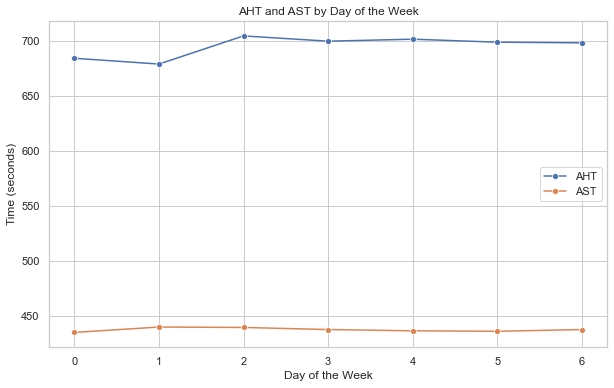

In [51]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='call_weekday', y='handle_time', data=weekday_analysis, label='AHT', marker='o')
sns.lineplot(x='call_weekday', y='waiting_time', data=weekday_analysis, label='AST', marker='o')
plt.title('AHT and AST by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

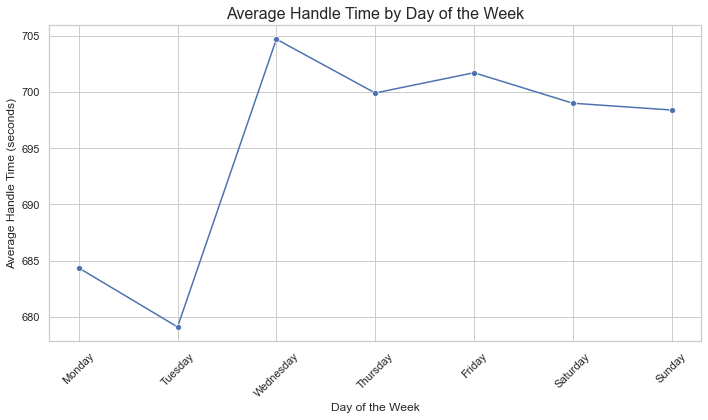

In [82]:



merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])


merged_data['call_day'] = merged_data['call_start_datetime'].dt.day_name()


day_group = merged_data.groupby('call_day')['handle_time'].mean().reset_index()


day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_group['call_day'] = pd.Categorical(day_group['call_day'], categories=day_order, ordered=True)

# Plot the line graph with days of the week on the x-axis
plt.figure(figsize=(10, 6))
sns.lineplot(x='call_day', y='handle_time', data=day_group, marker='o')

# Customize the x-axis to show day names
plt.xticks(rotation=45)
plt.title('Average Handle Time by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Handle Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()



# Primary call reason on weekday AND hours of the day with max AHT

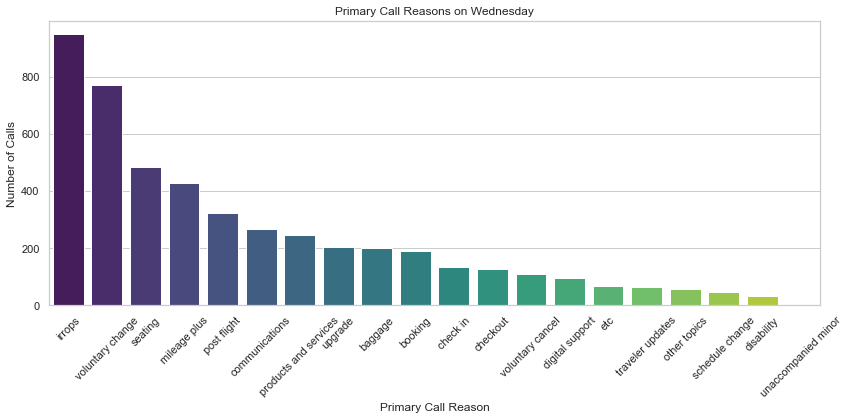

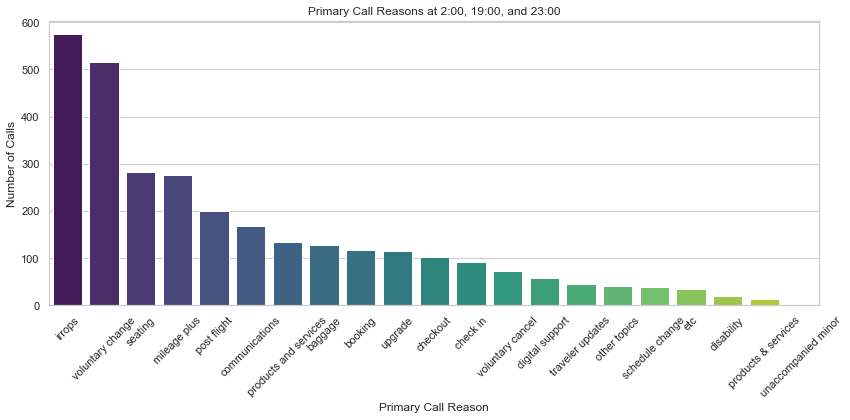

In [86]:
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])

merged_data['call_weekday'] = merged_data['call_start_datetime'].dt.weekday
merged_data['call_hour'] = merged_data['call_start_datetime'].dt.hour

wednesday_data = merged_data[merged_data['call_weekday'] == 2]

wednesday_reason_counts = wednesday_data['primary_call_reason'].value_counts().reset_index()
wednesday_reason_counts.columns = ['primary_call_reason', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='count', data=wednesday_reason_counts, palette='viridis')
plt.title('Primary Call Reasons on Wednesday')
plt.xlabel('Primary Call Reason')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

specific_times_data = merged_data[merged_data['call_hour'].isin([2, 19, 23])]

specific_time_reason_counts = specific_times_data['primary_call_reason'].value_counts().reset_index()
specific_time_reason_counts.columns = ['primary_call_reason', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(x='primary_call_reason', y='count', data=specific_time_reason_counts, palette='viridis')
plt.title('Primary Call Reasons at 2:00, 19:00, and 23:00')
plt.xlabel('Primary Call Reason')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


# Agent performance analysis

In [54]:

agent_performance = merged_data.groupby('agent_id').agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count',  # Total number of calls handled by the agent
}).reset_index()

agent_performance.sort_values(by='handle_time', ascending=False, inplace=True)

print(agent_performance.head(10))


     agent_id  handle_time  waiting_time  call_id
0      102574       3600.0    480.000000        2
160    506130       2880.0    420.000000        1
60     255256       2620.0    280.000000        3
16     140146       2620.0    360.000000        3
187    558705       1980.0    420.000000        2
13     136065       1800.0    420.000000        7
91     336455       1740.0    480.000000        3
280    780490       1680.0    380.000000        3
343    906082       1420.0    493.333333        9
115    384932       1350.0    600.000000        2


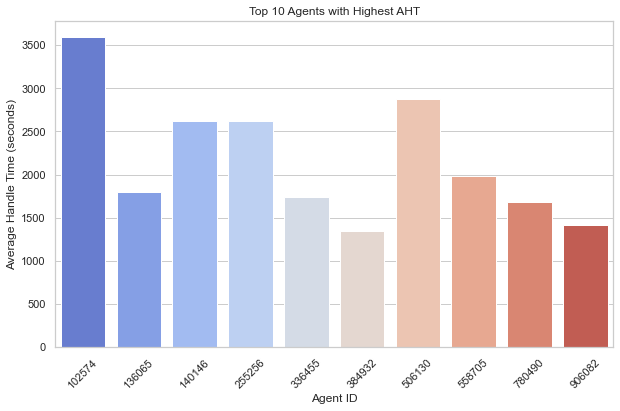

In [55]:
top_agents = agent_performance.nlargest(10, 'handle_time', )


plt.figure(figsize=(10, 6))
sns.barplot(x='agent_id', y='handle_time', data=top_agents, palette='coolwarm')
plt.title('Top 10 Agents with Highest AHT')
plt.xlabel('Agent ID')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45)
plt.show()


# Most frequent call reasons attended by agents with max AHT

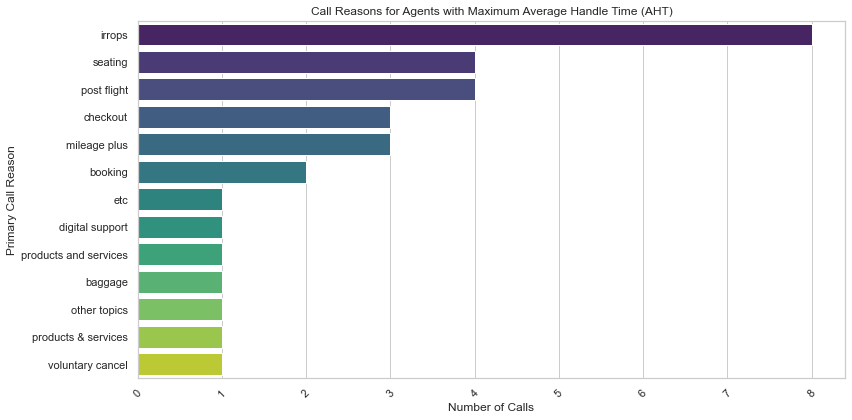

In [56]:
top_agent_ids = [
    102574, 506130, 255256, 140146, 558705,
    136065, 336455, 780490, 906082, 384932
]

# Step 1: Filter original dataset for these agent IDs
filtered_data = merged_data[merged_data['agent_id'].isin(top_agent_ids)]

# Step 2: Count call reasons for these agents
reason_counts = filtered_data['primary_call_reason'].value_counts().reset_index()
reason_counts.columns = ['primary_call_reason', 'count']

# Step 3: Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='primary_call_reason', data=reason_counts, palette='viridis')
plt.title('Call Reasons for Agents with Maximum Average Handle Time (AHT)')
plt.xlabel('Number of Calls')
plt.ylabel('Primary Call Reason')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

# Sentiment Analysis

In [59]:
# Group by sentiment score ranges (e.g., negative, neutral, positive)
sentiment_analysis = merged_data.groupby(pd.cut(merged_data['average_sentiment'], bins=[-1, 0.3, 0.7, 1], labels=["Negative", "Neutral", "Positive"])).agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count',
}).reset_index()

# Show the effect of sentiment on AHT and AST
print(sentiment_analysis)


  average_sentiment  handle_time  waiting_time  call_id
0          Negative   702.659214    436.918191    70848
1           Neutral   266.617100    448.029740      807
2          Positive   213.750000    427.500000       16


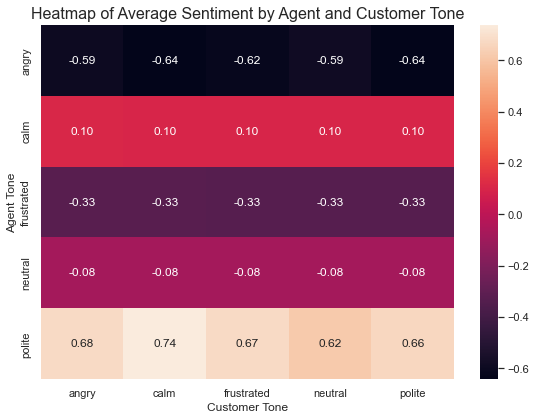

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table to calculate average sentiment scores between agent and customer tones
sentiment_pivot = merged_data.pivot_table(index='agent_tone', columns='customer_tone', values='average_sentiment', aggfunc='mean')

# Plot a heatmap of the sentiment correlation between agent tone and customer tone
plt.figure(figsize=(8, 6))
sns.heatmap(sentiment_pivot, annot=True,  fmt='.2f')

plt.title('Heatmap of Average Sentiment by Agent and Customer Tone', fontsize=16)
plt.xlabel('Customer Tone', fontsize=12)
plt.ylabel('Agent Tone', fontsize=12)

plt.tight_layout()
plt.show()


A negative correlation between agent & customer tone can be a reason for more AHT

# Correlation between AHT , AST , Silence percentage and Sentiment score


In [61]:
# Correlation analysis
correlation_matrix = merged_data[['handle_time', 'waiting_time', 'agent_tone', 'customer_tone', 'average_sentiment', 'silence_percent_average']].corr()

print("Correlation Matrix: \n", correlation_matrix)


Correlation Matrix: 
                          handle_time  waiting_time  average_sentiment  \
handle_time                 1.000000     -0.027778          -0.076065   
waiting_time               -0.027778      1.000000           0.039881   
average_sentiment          -0.076065      0.039881           1.000000   
silence_percent_average     0.406883     -0.012068           0.035339   

                         silence_percent_average  
handle_time                             0.406883  
waiting_time                           -0.012068  
average_sentiment                       0.035339  
silence_percent_average                 1.000000  


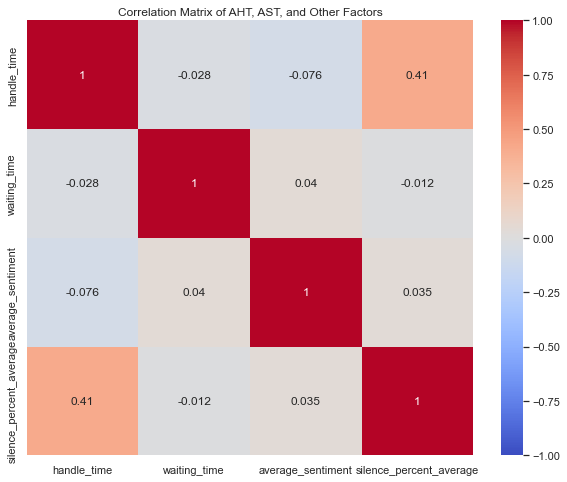

In [62]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of AHT, AST, and Other Factors')
plt.show()

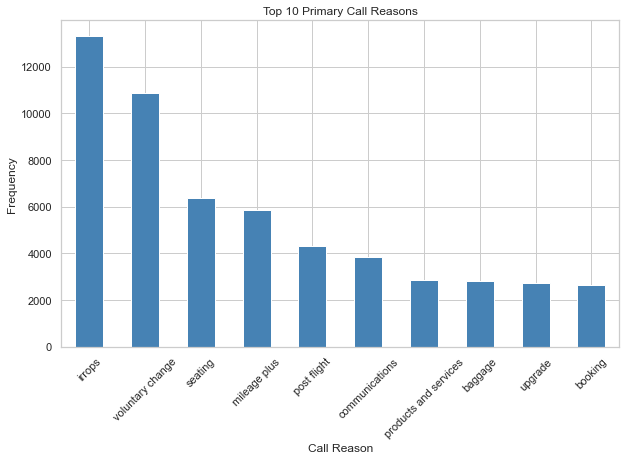

In [65]:
reason_counts = merged_data['primary_call_reason'].value_counts()

# Create a bar plot for the top call reasons
plt.figure(figsize=(10, 6))
reason_counts[:10].plot(kind='bar', color='steelblue')
plt.title('Top 10 Primary Call Reasons')
plt.xlabel('Call Reason')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [66]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71810 entries, 0 to 71809
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id                 71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
 7   primary_call_reason      66653 non-null  object        
 8   agent_tone               71593 non-null  object        
 9   customer_tone            71810 non-null  object        
 10  average_sentiment        71701 non-null  float64       
 11  silence_percent_average  71810 non-null  float64       
 12  customer_name            71810 n

# AHT and AST by customer elite level

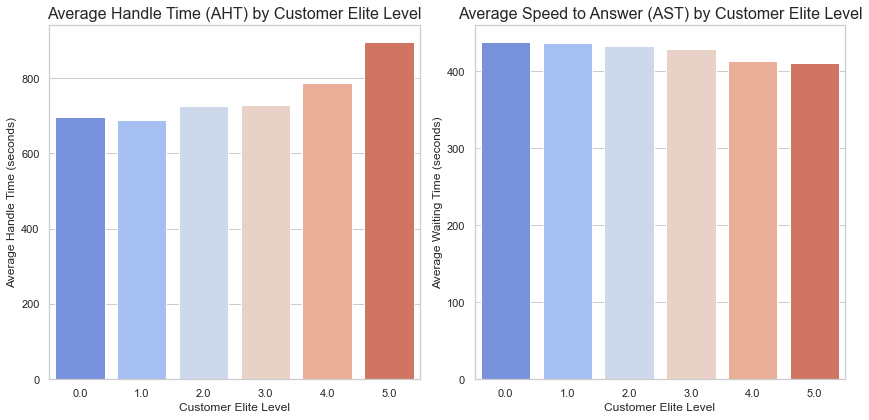

In [67]:
elite_performance = merged_data.groupby('elite_level_code').agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count'
}).reset_index()

elite_performance.rename(columns={'call_id': 'total_calls'}, inplace=True)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='elite_level_code', y='handle_time', data=elite_performance, palette='coolwarm')
plt.title('Average Handle Time (AHT) by Customer Elite Level', fontsize=16)
plt.xlabel('Customer Elite Level', fontsize=12)
plt.ylabel('Average Handle Time (seconds)', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='elite_level_code', y='waiting_time', data=elite_performance, palette='coolwarm')
plt.title('Average Speed to Answer (AST) by Customer Elite Level', fontsize=16)
plt.xlabel('Customer Elite Level', fontsize=12)
plt.ylabel('Average Waiting Time (seconds)', fontsize=12)

plt.tight_layout()
plt.show()


# percentage difference between the AHT for the most frequent and least frequent call reasons

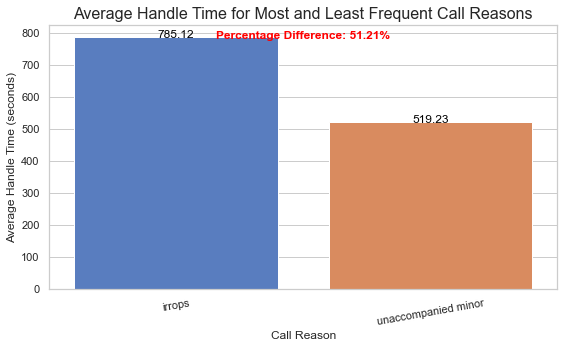

Most Frequent Call Reason: irrops with AHT: 785.12 seconds
Least Frequent Call Reason: unaccompanied minor with AHT: 519.23 seconds
Percentage Difference in AHT: 51.21%


In [68]:
call_reason_frequency = merged_data['primary_call_reason'].value_counts().reset_index()
call_reason_frequency.columns = ['primary_call_reason', 'frequency']

average_handle_time_by_reason = merged_data.groupby('primary_call_reason')['handle_time'].mean().reset_index()
average_handle_time_by_reason.columns = ['primary_call_reason', 'average_handle_time']

reason_performance = pd.merge(call_reason_frequency, average_handle_time_by_reason, on='primary_call_reason')

most_frequent_reason = reason_performance.loc[reason_performance['frequency'].idxmax()]
least_frequent_reason = reason_performance.loc[reason_performance['frequency'].idxmin()]

most_frequent_aht = most_frequent_reason['average_handle_time']
least_frequent_aht = least_frequent_reason['average_handle_time']

percentage_difference = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

data_to_plot = {
    'Call Reason': [most_frequent_reason['primary_call_reason'], least_frequent_reason['primary_call_reason']],
    'Average Handle Time (seconds)': [most_frequent_aht, least_frequent_aht]
}

plot_df = pd.DataFrame(data_to_plot)

plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='Call Reason', y='Average Handle Time (seconds)', data=plot_df, palette='muted')

plt.title('Average Handle Time for Most and Least Frequent Call Reasons', fontsize=16)
plt.ylabel('Average Handle Time (seconds)', fontsize=12)
plt.xlabel('Call Reason', fontsize=12)
plt.xticks(rotation=10)

for index, value in enumerate(plot_df['Average Handle Time (seconds)']):
    barplot.text(index, value + 0.5, f'{value:.2f}', color='black', ha='center')

plt.text(0.5, max(plot_df['Average Handle Time (seconds)']) - 5, 
         f'Percentage Difference: {percentage_difference:.2f}%', 
         fontsize=12, ha='center', color='red', weight='bold')

plt.tight_layout()
plt.show()

print(f"Most Frequent Call Reason: {most_frequent_reason['primary_call_reason']} "
      f"with AHT: {most_frequent_aht:.2f} seconds")
print(f"Least Frequent Call Reason: {least_frequent_reason['primary_call_reason']} "
      f"with AHT: {least_frequent_aht:.2f} seconds")
print(f"Percentage Difference in AHT: {percentage_difference:.2f}%")


# Transcript and Call reasons Analysis

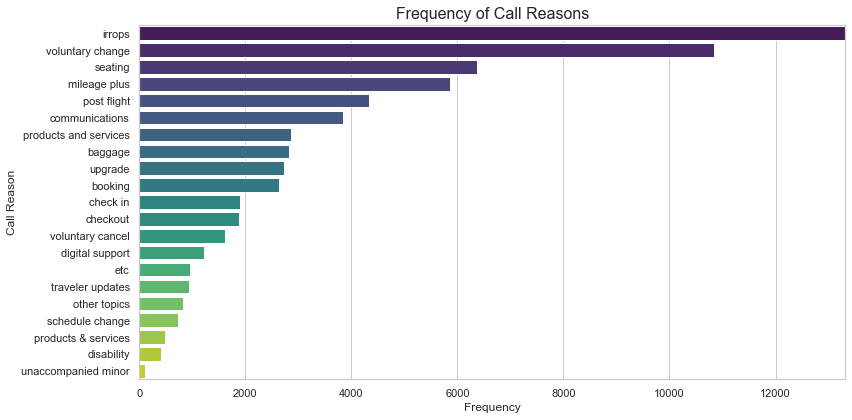

In [121]:
call_reason_counts = merged_data['primary_call_reason'].value_counts().reset_index()
call_reason_counts.columns = ['Call Reason', 'Frequency']

call_reason_counts = call_reason_counts.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Call Reason', data=call_reason_counts, palette='viridis')

plt.title('Frequency of Call Reasons', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Call Reason', fontsize=12)
plt.xlim(0, call_reason_counts['Frequency'].max() + 5)  

plt.tight_layout()
plt.show()

      primary_call_reason  handle_time  waiting_time  call_id
3                checkout  1016.853814    724.703390     1888
9            mileage plus   995.573406    361.015211     5851
7                     etc   962.899160    544.285714      952
11            post flight   932.896074    569.431871     4330
4          communications   826.718750    239.968750     3840
8                  irrops   785.116069    360.081136    13311
13  products and services   750.966387    303.214286     2856
19       voluntary cancel   721.866833    539.514624     1607
12    products & services   720.126050    297.857143      476
20       voluntary change   639.153761    540.486726    10848
18                upgrade   632.344777    298.487947     2738
2                check in   574.128151    355.840336     1904
17    unaccompanied minor   519.230769    688.269231      104
14        schedule change   490.013680    240.820793      731
15                seating   474.994501    570.824823     6365
1       

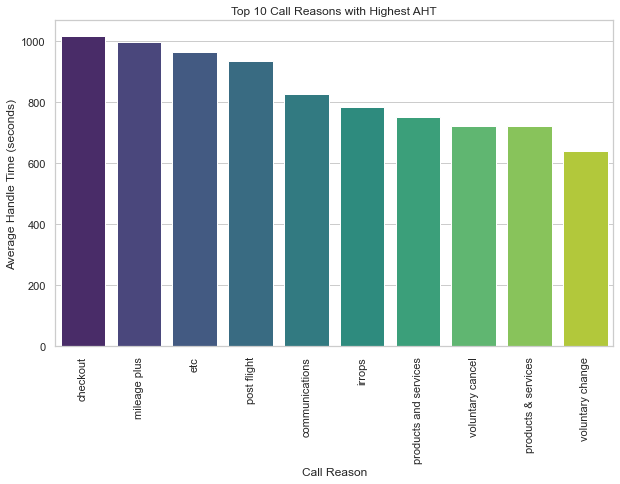

In [122]:
call_reason_analysis = merged_data.groupby('primary_call_reason').agg({
    'handle_time': 'mean',
    'waiting_time': 'mean',
    'call_id': 'count', 
}).reset_index()

call_reason_analysis.sort_values(by='handle_time', ascending=False, inplace=True)

print(call_reason_analysis)

top_call_reasons = call_reason_analysis.nlargest(10, 'handle_time')

plt.figure(figsize=(10, 6))
sns.barplot(x='primary_call_reason', y='handle_time', data=top_call_reasons, palette='viridis')
plt.title('Top 10 Call Reasons with Highest AHT')
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=90)
plt.show()

Call Reasons with maximum AHT.

# prediction of test.cv

In [120]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


test_data = pd.read_csv('testbc7185d.csv')


train_data = merged_data.dropna(subset=['primary_call_reason'])

train_data['call_transcript'] = train_data['call_transcript'].fillna('')  # Replace NaN in transcripts with empty string
train_data['average_sentiment'] = train_data['average_sentiment'].fillna(train_data['average_sentiment'].mean())  # Fill NaN with mean
train_data['handle_time'] = train_data['handle_time'].replace([np.inf, -np.inf], np.nan).fillna(train_data['handle_time'].mean())  # Replace inf with mean
train_data['waiting_time'] = train_data['waiting_time'].replace([np.inf, -np.inf], np.nan).fillna(train_data['waiting_time'].mean())  # Replace inf with mean


tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(train_data['call_transcript'])

X_train = pd.concat([pd.DataFrame(X_train_tfidf.toarray()), train_data[['average_sentiment', 'handle_time', 'waiting_time']].reset_index(drop=True)], axis=1)
y_train = train_data['primary_call_reason']


X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(X_train_split, y_train_split)


y_pred = model.predict(X_val_split)
print('Accuracy:', accuracy_score(y_val_split, y_pred))
print('Classification Report:', classification_report(y_val_split, y_pred))


test_data = test_data.merge(merged_data[['call_id', 'call_transcript', 'average_sentiment', 'handle_time', 'waiting_time']], on='call_id', how='left')


test_data['call_transcript'] = test_data['call_transcript'].fillna('')
test_data['average_sentiment'] = test_data['average_sentiment'].fillna(train_data['average_sentiment'].mean())
test_data['handle_time'] = test_data['handle_time'].replace([np.inf, -np.inf], np.nan).fillna(train_data['handle_time'].mean())
test_data['waiting_time'] = test_data['waiting_time'].replace([np.inf, -np.inf], np.nan).fillna(train_data['waiting_time'].mean())

X_test_tfidf = tfidf.transform(test_data['call_transcript'])
X_test = pd.concat([pd.DataFrame(X_test_tfidf.toarray()), test_data[['average_sentiment', 'handle_time', 'waiting_time']].reset_index(drop=True)], axis=1)


test_data['predicted_call_reason'] = model.predict(X_test)

test_data[['call_id', 'predicted_call_reason']].to_csv('predicted_call_reasons.csv', index=False)


C:\Users\bhard\AppData\Local\Temp/ipykernel_24828/125026599.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['call_transcript'] = train_data['call_transcript'].fillna('')  # Replace NaN in transcripts with empty string
C:\Users\bhard\AppData\Local\Temp/ipykernel_24828/125026599.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['average_sentiment'] = train_data['average_sentiment'].fillna(train_data['average_sentiment'].mean())  # Fill NaN with mean
C:\Users\bhard\AppData\Local\T

Accuracy: 0.3314079963993699


C:\Users\bhard\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhard\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhard\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:                        precision    recall  f1-score   support

              baggage       0.00      0.00      0.00       604
              booking       0.28      0.03      0.06       513
             check in       0.00      0.00      0.00       359
             checkout       0.80      0.10      0.17       384
       communications       0.30      0.02      0.04       757
      digital support       0.00      0.00      0.00       255
           disability       0.00      0.00      0.00        86
                  etc       0.00      0.00      0.00       197
               irrops       0.34      0.95      0.50      2763
         mileage plus       0.20      0.04      0.07      1130
         other topics       0.00      0.00      0.00       174
          post flight       0.43      0.18      0.26       848
  products & services       0.00      0.00      0.00        86
products and services       0.00      0.00      0.00       572
      schedule change       0.0